<a href="https://colab.research.google.com/github/DrAlexSanz/nlpv2-course/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from wordcloud import WordCloud

In [ ]:
# Get the data

!wget https://lazyprogrammer.me/course_files/spam.csv

--2022-08-03 12:07:11--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K   890KB/s    in 0.6s    

2022-08-03 12:07:12 (890 KB/s) - ‘spam.csv.1’ saved [503663/503663]



In [ ]:
df = pd.read_csv("spam.csv", encoding = "ISO-8859-1")

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Drop weird columns

df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
df.columns = ["labels", "data"]
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


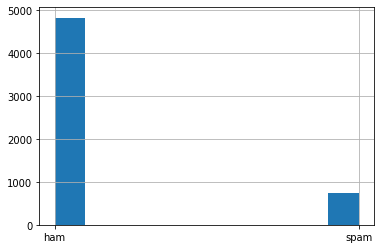

In [ ]:
# See if it's 50-50

df["labels"].hist() # There are very few spam emails, imbalanced as the golden customers

In [ ]:
# Create binary labels. Scikit learn now accepts strings as labels but let's do it binary in case I want to use something else in the future

df["b_labels"] = df["labels"].map({"ham": 0, "spam": 1})
y = df["b_labels"].to_numpy()

In [ ]:
# Split data

x_train_text, x_test_text, y_train, y_test = train_test_split(df["data"], y, test_size = 0.2)
x_train_text.head()

874     Talk With Yourself Atleast Once In A Day...!!!...
1835                         * Will be september by then!
5539                           Just sleeping..and surfing
4502                              Stupid.its not possible
2694    Hey sexy buns! What of that day? No word from ...
Name: data, dtype: object

In [ ]:
# Create training matrix

featurizer = CountVectorizer(decode_error = "ignore") # Try TFidf vectorizer
x_train = featurizer.fit_transform(x_train_text)
x_test = featurizer.transform(x_test_text)
x_train

<4457x7741 sparse matrix of type '<class 'numpy.int64'>'
	with 59487 stored elements in Compressed Sparse Row format>

In [ ]:
model = MultinomialNB()
model_svc = SVC(class_weight = "balanced") # This one has support for imbalanced classes and I just wanted to try it. Anyway the NB is good enough.

model.fit(x_train, y_train)
print("Train accuracy = ", model.score(x_train, y_train))
print("Test accuracy = ", model.score(x_test, y_test))

model_svc.fit(x_train, y_train)
print("Train_svc accuracy = ", model_svc.score(x_train, y_train))
print("Test_svc accuracy = ", model_svc.score(x_test, y_test))

Train accuracy =  0.9932690150325331
Test accuracy =  0.989237668161435
Train_svc accuracy =  0.9995512676688355
Test_svc accuracy =  0.9829596412556054


Keep in mind, this is accuracy and it's imbalanced. Look at F1 or precision

In [ ]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
print("Train f1 score = ", f1_score(y_train, pred_train))
print("Test f1 score", f1_score(y_test, pred_test))

pred_train_svc = model_svc.predict(x_train)
pred_test_svc = model_svc.predict(x_test)
print("Train_svc f1 score = ", f1_score(y_train, pred_train_svc))
print("Test_svc f1 score", f1_score(y_test, pred_test_svc))

Train f1 score =  0.9750415973377704
Test f1 score 0.9571428571428573
Train_svc f1 score =  0.9983471074380166
Test_svc f1 score 0.9304029304029305


In [ ]:
prob_train = model.predict_proba(x_train)[:, 1]
prob_test = model.predict_proba(x_test)[:, 1]

print("Train AUC = ", roc_auc_score(y_train, prob_train))
print("Test AUC = ", roc_auc_score(y_test, prob_test))

Train AUC =  0.9932772928949649
Test AUC =  0.9776645484417296


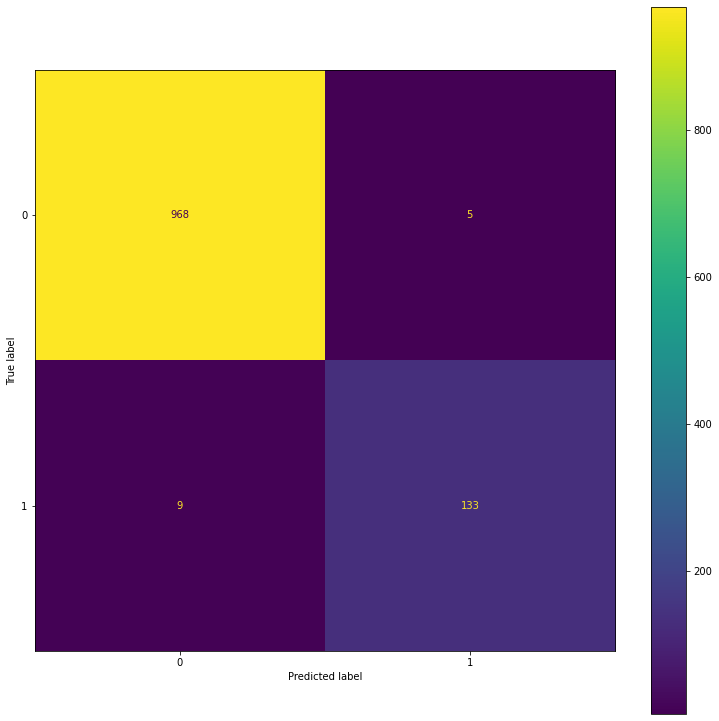

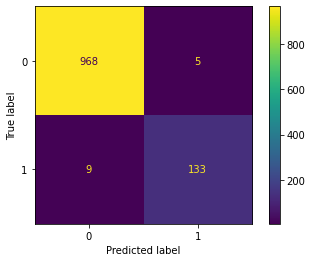

In [ ]:
fig, ax = plt.subplots(figsize = (13, 13))
cm = ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, normalize = None)
cm.plot(ax = ax)

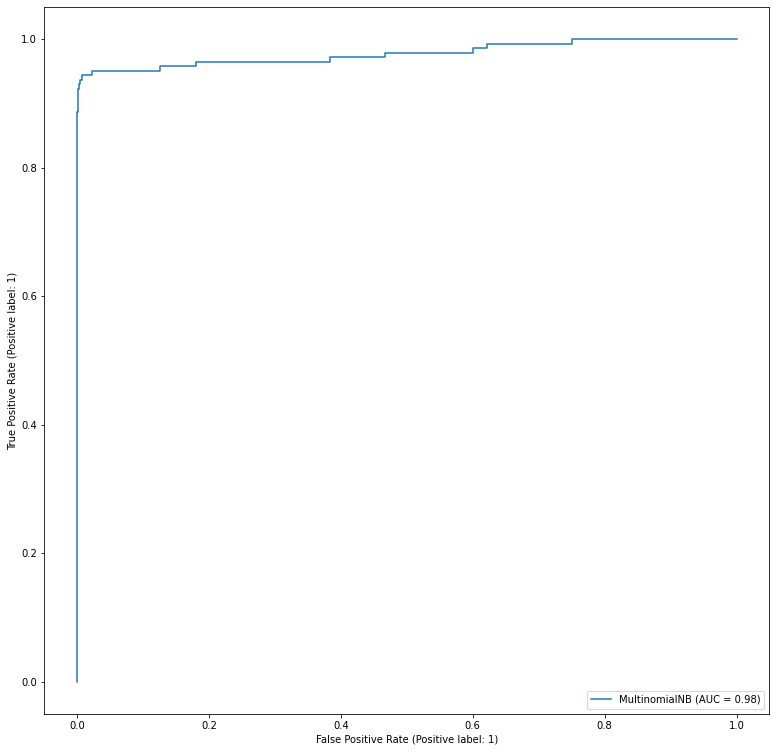

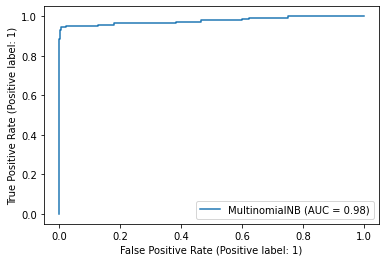

In [ ]:
fig, ax = plt.subplots(figsize = (13, 13))
cm = RocCurveDisplay.from_estimator(model, x_test, y_test)
cm.plot(ax = ax)

## Now let's make a nice wordcloud to see which words are contained in each label generally

In [ ]:
def visualize_labels(label):
    """Given a label ham/spam make a word cloud and a plot"""

    words = ""
    for msg in df[df["labels"] == label]["data"]:
        msg = msg.lower()
        words += msg + " " # Add a space to each word

    wordcloud = WordCloud(width = 600, height = 400).generate(words)

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    return
    

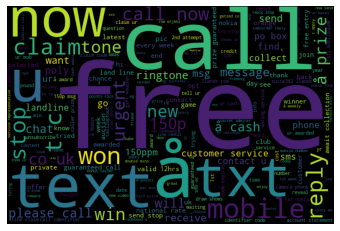

In [ ]:
visualize_labels("spam")

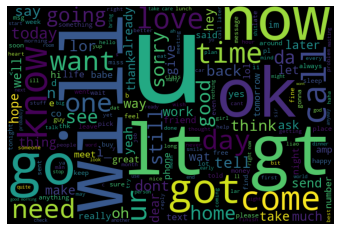

In [ ]:
visualize_labels("ham") # Clearly different words, it's not bad, but it's powerful and simple

In [ ]:
# See what we are predicting wrongly. It's always worth checking the data before the classification anyway

X = featurizer.transform(df["data"])
df["predictions"] = model.predict(X)

In [ ]:
# False negatives: Things that should be predicted as spam but they are not

sneaky_spam = df[(df["predictions"] == 0) & (df["labels"] == "spam")]["data"]

for msg in sneaky_spam:
    print(msg + "\n")

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv

Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"

Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?

Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.

Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r

Can U get 2 phone NOW? I wanna chat 2 set up meet Call me NOW on 09096102316 U can cum here 2moro Luv JANE xx Callså£1/minmoremobsEMSPOBox45PO139WA

Would you like to see my XXX pics they are so hot they were nearly banned in the uk!

Hi ya babe x u 4goten bout me?' scammers getting smart..Though this is a regular vodafone no, if you respond you get further prem rate msg/subscrip

In [ ]:
# False positives: Things that should be predicted as ham but they are predicted as spam

false_positives = df[(df["predictions"] == 1) & (df["labels"] == "ham")]["data"]

for msg in false_positives:
    print(msg + "\n")

Yes:)from last week itself i'm taking live call.

Waiting for your call.

Can u get pic msgs to your phone?

We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us

Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May

Yavnt tried yet and never played original either

Unlimited texts. Limited minutes.

Mathews or tait or edwards or anderson

Gettin rdy to ship comp

I liked the new mobile

Anytime...

Nokia phone is lovly..

We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us

